In [291]:
%matplotlib inline

import os
import glob
import math
import string
import random
from io import BytesIO

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.transform import rescale, rotate

import barcode
from barcode.writer import ImageWriter

In [85]:
# barcode.PROVIDED_BARCODES.remove('pzn')
barcode.PROVIDED_BARCODES

['code128',
 'code39',
 'ean',
 'ean13',
 'ean14',
 'ean8',
 'gs1',
 'gtin',
 'isbn',
 'isbn10',
 'isbn13',
 'issn',
 'itf',
 'jan',
 'upc',
 'upca']

In [120]:
digits = string.digits
alphanums = digits + string.ascii_uppercase + '.+-$/% '
codes = barcode.PROVIDED_BARCODES
random.seed(8)

def gen_rand_chars(num, digit_only=True):
    if digit_only:
        return ''.join(random.choice(digits) for i in range(num))
    else:
        return ''.join(random.choice(alphanums) for i in range(num))


def gen_barcodes(num, output_dir):
    for i in range(num):
        code = random.choice(codes)
        with open(os.path.join(output_dir, '%06d.png' % i), 'wb') as fp:
            if code.startswith('code'):
                num = random.randint(1, 20)
                barcode.generate(code, gen_rand_chars(num, False), writer=ImageWriter(), output=fp)
            elif code.startswith('is') or code.startswith('gs1'):
                barcode.generate(code, '978' + gen_rand_chars(17), writer=ImageWriter(), output=fp)
            elif code.startswith('jan'):
                barcode.generate(code, '455' + gen_rand_chars(17), writer=ImageWriter(), output=fp)
            else:
                barcode.generate(code, gen_rand_chars(20), writer=ImageWriter(), output=fp)

In [121]:
# gen_barcodes(2000, output_dir='barcodes')

In [306]:
def gen_rand_bg(bgs, desired_w=640, desired_h=640):
    bg = random.choice(glob.glob(bgs))
    im = plt.imread(bg)
    h, w, d = im.shape
    r = random.randint(0, h-desired_h)
    c = random.randint(0, w-desired_w)
    return im[r:r+desired_h, c:c+desired_w, :]
    

def merge(bg_im, barcode_im, output):
    if bg_im.dtype.name == 'uint8':
        bg_im = bg_im.astype('float32')/255
    if barcode_im.dtype.name == 'uint8':
        barcode_im = barcode_im.astype('float32')/255
    
    h1, w1, d1 = bg_im.shape
    h2, w2, d2 = barcode_im.shape
    
    if random.random() > 0.5:
        deg = random.randint(1, 359)
#         print('rotate deg', deg)
        barcode_im = rotate(barcode_im, deg,resize=True, mode='constant', cval=-1)
        h2, w2, d2 = barcode_im.shape
    
    sf = random.uniform(0.4, 0.9)
    barcode_im = rescale(barcode_im, sf, multichannel=True)
    h2, w2, d2 = barcode_im.shape
    while h2>h1 or w2>w1:
        sf = random.uniform(0.4, 0.9)
    #   print('scale factor', sf)
        barcode_im = rescale(barcode_im, sf, multichannel=True)
        h2, w2, d2 = barcode_im.shape

    r = random.randint(0, h1-h2)
    c = random.randint(0, w1-w2)
    tmp = barcode_im==-1
    barcode_im[tmp] = bg_im[r:r+h2, c:c+w2, :][tmp]
    bg_im[r:r+h2, c:c+w2, :] = barcode_im
    plt.imsave(output, bg_im)

#     plt.figure(figsize=(18, 16))
#     fig, ax = plt.subplots(1)
#     rect = patches.Rectangle((c, r), w2, h2, linewidth=1, edgecolor='r', facecolor='none')
#     ax.add_patch(rect)
#     ax.imshow(bg_im)
    return c, r, w2, h2

In [307]:
NUM_SAMPLE = 20000
input_bgs = './bg/*jpg'
input_barcodes = './barcodes/*png'
output_dir = './images'

barcode_files = glob.glob(input_barcodes)
bboxes = np.zeros((NUM_SAMPLE, 4), dtype=np.int32)
for i in range(NUM_SAMPLE):
    barcode = plt.imread(random.choice(barcode_files))
    output = os.path.join(output_dir, '%06d.jpg' % i)
    bboxes[i] = merge(gen_rand_bg(input_bgs), barcode, output)
np.savetxt('bbox.csv', bboxes, '%d')

/home/kris/.virtualenvs/charrnn/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/kris/.virtualenvs/charrnn/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(280, 551, 3) float32 (588, 588, 3) float64


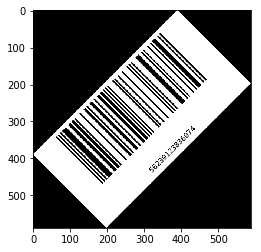

In [282]:
from skimage.transform import rescale, rotate
im3 = rotate(im2, 45, resize=True, mode='constant', cval=0)
# im3 = im2+im3[:-1, :, :]
# im3[im3>1] = 1
print(im2.shape, im2.dtype, im3.shape, im3.dtype)
plt.imshow(im3)

In [311]:
# yolo format
output_yolo_file = './images/%06d.txt'
desired_w=640
desired_h=640
bboxes = np.loadtxt('bbox.csv')
for i in range(bboxes.shape[0]):
    with open(output_yolo_file % i, 'wb') as fout:
        fout.write(('0 %f %f %f %f' % ((bboxes[i, 0]+bboxes[i, 2]/2)/desired_w,
                                      (bboxes[i, 1]+bboxes[i, 3]/2)/desired_h,
                                      bboxes[i, 2]/desired_w,
                                      bboxes[i, 3]/desired_h
                                     )).encode('utf8'))

In [314]:
train_file = 'train.txt'
test_file = 'test.txt'
train_test_split = 0.75
yolo_annots = glob.glob('/yfsdata/multi-barcode/images/*jpg')
random.shuffle(yolo_annots)
split_point = int(train_test_split * len(yolo_annots))
with open(train_file, 'wb') as fout:
    fout.write(('\n'.join(yolo_annots[:split_point])).encode('utf8'))
with open(test_file, 'wb') as fout:
    fout.write(('\n'.join(yolo_annots[split_point:])).encode('utf8'))

In [316]:
# ./darknet detector calc_anchors /yfsdata/multi-barcode/barcode.data -num_of_clusters 9 -width 608 -height 608
# ./darknet detector train /yfsdata/multi-barcode/barcode.data /yfsdata/multi-barcode/yolo.cfg /home/kris/darknet/darknet53.conv.74 -gpus 0,1
./darknet detector map /yfsdata/multi-barcode/barcode.data /yfsdata/multi-barcode/yolo.cfg ~/barcode_backup/yolo.backup

In [319]:
#pascal format
import xml.etree.ElementTree as ET

input_ims = './images/%06d.jpg'
output_pascal_xml = './annots/%06d.xml'
desired_w=640
desired_h=640
bboxes = np.loadtxt('bbox.csv').astype('int32')
for i in range(bboxes.shape[0]):
# for i in range(1):
    annot = ET.Element('annotation')
    ET.SubElement(annot, 'filename').text = '%06d.jpg' % i
    ET.SubElement(annot, 'folder').text = 'images'
    ET.SubElement(annot, 'path').text = os.path.abspath(input_ims % i)
    ET.SubElement(annot, 'segmented').text = '0'
    size = ET.SubElement(annot, 'size')
    ET.SubElement(size, 'width').text = str(desired_w)
    ET.SubElement(size, 'height').text = str(desired_h)
    ET.SubElement(size, 'depth').text = '3'
    
    obj = ET.SubElement(annot, 'object')
    ET.SubElement(obj, 'name').text = 'barcode'
    ET.SubElement(obj, 'pose').text = 'Unspecified'
    ET.SubElement(obj, 'truncated').text = '0'
    ET.SubElement(obj, 'difficult').text = '0'

    bndbox = ET.SubElement(obj, 'bndbox')
    ET.SubElement(bndbox, 'xmax').text = str(bboxes[i, 0]+bboxes[i, 2])
    ET.SubElement(bndbox, 'xmin').text = str(bboxes[i, 0])
    ET.SubElement(bndbox, 'ymax').text = str(bboxes[i, 1]+bboxes[i, 3])
    ET.SubElement(bndbox, 'ymin').text = str(bboxes[i, 1])

    with open(output_pascal_xml % i, 'wb') as fout:
        fout.write(ET.tostring(annot))
print('done')

done
